#**Fried Onions Classifier**
This is a quick proof-of-concept study that analyses an image dataset of fried/frying onions in a pan, and classifies the onions as **Not Done Yet (0)** or **All Set (1)**.

###**To-Do List:**
- [X] Prepare Image dataset
- [X] Set up the necessary tools in Jupyter Notebook
- [X] Decide on CNN Architecture to be used
- [X] Train 
- [X] Test it out
- [ ] Refine and Iterate

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

class LeNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialisation of model
    model = Sequential()
    inputShape = (height, width, depth)
    #in case the channel comes first
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
    #first set of CONV => RELU => POOL layers
    model.add(Conv2D((20), (5, 5), padding = "same", input_shape = inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    #second set of CONV => RELU => POOL layers
    model.add(Conv2D((50), (5, 5), padding = "same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    #finally, flattening and fully connected layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    #softmax classifier to yield class probability
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model

# Next Step
Now that the model architecture has been layed out in detail, it's time to train the model on our image dataset. The dataset is relatively sparse for now, containing 286 images of both fried and not-fried onions. However, once the model has been trained once, we can take a look at refining the dataset for better performance.

In [ ]:
# configure backend to save plots in the background
import matplotlib
matplotlib.use("Agg")

#import required packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

%matplotlib inline

In [ ]:
#to parse input arguments based on which training parameters and outputs will be configured
#this will be refactored to prevent errors on Colab and Jupyter Notebooks
"""
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required = True, help = "path to input dataset")
ap.add_argument("-m", "--model", required = True, help = "path to output model")
ap.add_argument("-p", "--plot", type = str, default = "plot.png", help = "path to output loss/accuracy plot")
"""
#this is to facilitate running the model in one notebook file instead of calling the program with command line arguments
args = {"dataset": "images", "model": "fried_not_fried_onion.model", "plot": "plot.png"}

In [ ]:
#now, to initialise the number of epochs, learning rate and batch size
EPOCHS = 25
INIT_LR = 1e-3
BS = 16

#to initialise the data and labels
print("[INFO] loading images...")
data = []
labels = []

#retrieve image paths and perform random shuffle
imagePaths = sorted(list(paths.list_images(args["dataset"])))
random.seed(69420)
random.shuffle(imagePaths)

[INFO] loading images...


In [ ]:
#now, to preprocess the images
#first, loop over input images
for imagePath in imagePaths:
  #load, preprocess and store in data list
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (28, 28))
  image = img_to_array(image)
  data.append(image)

  #extract class label from the image path and update labels list
  label = imagePath.split(os.path.sep)[-2]
  label = 1 if label == "fried" else 0
  labels.append(label)

In [ ]:
#now, to scale pixel intensities down to [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

#partitioning into train/test splits, using 90% for training and 10% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.1, random_state = 69420)

#convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes = 2)
testY = to_categorical(testY, num_classes = 2)

In [ ]:
aug = ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = "nearest")

In [ ]:
#initialise the model
print("[INFO] compiling model...")
model = LeNet.build(width = 28, height = 28, depth = 3, classes = 2)
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

#training the network
print("[INFO] training network...")
H = model.fit(x = aug.flow(trainX, trainY, batch_size = BS), validation_data = (testX, testY), steps_per_epoch = len(trainX) // BS, epochs = EPOCHS, verbose = 1)

#save the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format = "h5")

[INFO] compiling model...
[INFO] training network...
Epoch 1/25
32/32 [==============================] - 2s 57ms/step - loss: 0.6530 - accuracy: 0.6064 - val_loss: 0.3471 - val_accuracy: 0.8793
Epoch 2/25
32/32 [==============================] - 2s 56ms/step - loss: 0.3268 - accuracy: 0.8695 - val_loss: 0.2776 - val_accuracy: 0.9138
Epoch 3/25
32/32 [==============================] - 2s 55ms/step - loss: 0.3031 - accuracy: 0.8775 - val_loss: 0.2710 - val_accuracy: 0.8448
Epoch 4/25
32/32 [==============================] - 2s 54ms/step - loss: 0.2725 - accuracy: 0.8936 - val_loss: 0.4005 - val_accuracy: 0.8276
Epoch 5/25
32/32 [==============================] - 2s 55ms/step - loss: 0.2848 - accuracy: 0.8876 - val_loss: 0.2632 - val_accuracy: 0.8448
Epoch 6/25
32/32 [==============================] - 2s 58ms/step - loss: 0.2688 - accuracy: 0.9076 - val_loss: 0.3459 - val_accuracy: 0.8621
Epoch 7/25
32/32 [==============================] - 2s 51ms/step - loss: 0.2932 - accuracy: 0.8926 - 

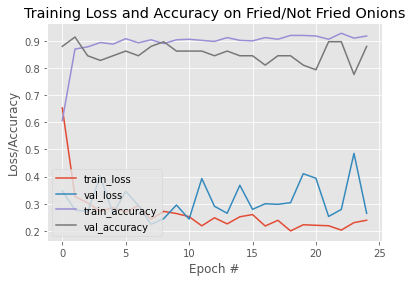

In [ ]:
#plot the traiing loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Loss and Accuracy on Fried/Not Fried Onions")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.plot()
plt.savefig(args["plot"])

# Testing the Model with New Images

Now that the model has been trained, we check out some correctly classified images

In [ ]:
#import the necessary packages
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import imutils

In [ ]:
#load a test image of fried onions
args = {"image": "images/test_image_fried.jpeg", "model": "fried_not_fried_onion.model"}
image = cv2.imread(args["image"])
orig = image.copy()

#resize the image to fit it to our needs
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis = 0)

In [ ]:
#load the model previously trained and run the predictions
print("[INFO] loading network")
model = load_model(args["model"])

NotFried, Fried = model.predict(image)[0]

[INFO] loading network


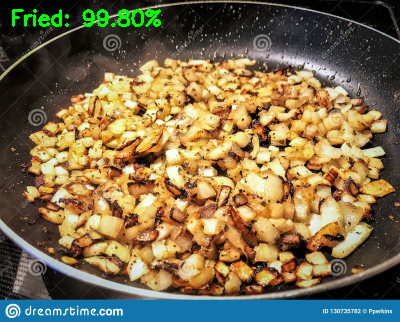

In [ ]:
#building the label
label = "Fried" if Fried > NotFried else "Not Fried"
probability = Fried if label == "Fried" else NotFried
label = "{}: {:.2f}%".format(label, probability * 100)

#print the label and probability over original image
output = imutils.resize(orig, width = 400)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255.0, 0), 2)

cv2_imshow(output)

In [ ]:
#another image to be loaded with raw onions (not yet fried)
args = {"image": "images/test_image_not_fried.jpeg", "model": "fried_not_fried_onion.model"}
image = cv2.imread(args["image"])
orig = image.copy()

#resize and configure for model
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis = 0)

In [ ]:
#load the model and run predictions
print("[INFO] loading network")
model = load_model(args["model"])

NotFried, Fried = model.predict(image)[0]

[INFO] loading network


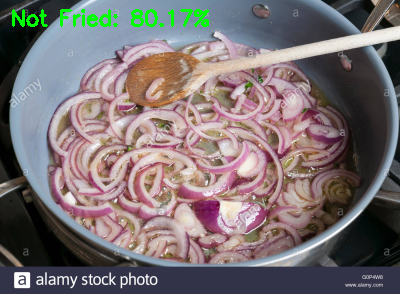

In [ ]:
#classify based on the model's results
label = "Fried" if Fried > NotFried else "Not Fried"
probability = Fried if label == "Fried" else NotFried
label = "{}: {:.2f}%".format(label, probability * 100)

#output the label and probability over original image 
output = imutils.resize(orig, width = 400)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255.0, 0), 2)

cv2_imshow(output)